# Employee Turnover Prediction

### Libraries

In [372]:
# importing the necessary modules
import requests
from bs4 import BeautifulSoup
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import os
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from pandasql import sqldf
import pandasql as psql
import statsmodels.api as sm  
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.datasets import load_iris

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score , mean_squared_error
import warnings

warnings.filterwarnings("ignore")

### Data Import

In [373]:
# Importing September data using pandas
FACTDATA_S = pd.read_csv("/Users/tejaswidodda/Documents/GMU/Spring 2022/DAEN 690/Jupyter_Code/SeptData/FACTDATA_SEP2021.txt")
# Importing June data using pandas
FACTDATA_J = pd.read_csv("/Users/tejaswidodda/Documents/GMU/Spring 2022/DAEN 690/Jupyter_Code/JuneData/FACTDATA_JUN2021.txt")
#merge data of both Sep and June using pandas
data = pd.concat([FACTDATA_S, FACTDATA_J], axis=0)
#data.head()
agysub = pd.read_csv("/Users/tejaswidodda/Documents/GMU/Spring 2022/DAEN 690/Jupyter_Code/JuneData/DTagy.txt")

In [416]:
#agysub = pd.read_csv("/Users/tejaswidodda/Documents/GMU/Spring 2022/DAEN 690/Jupyter_Code/JuneData/DTagy.txt")
DTwkstat = pd.read_csv("/Users/tejaswidodda/Documents/GMU/Spring 2022/DAEN 690/Jupyter_Code/JuneData/DTwkstat.txt")
DTwkstat

,WORKSTAT,WORKSTATT
0,1,Non-Seasonal Full Time Permanent
1,2,Other Employees


In [375]:
# Find null values grouped by agency
dflist1 = data.columns
# creating a new column with sum of null values in each row
dn = data.groupby(['AGYSUB'])[dflist1].apply(lambda x: x.isnull().sum())
dn['results'] = dn.sum(axis = 1)
dn.head()

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,...,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS,results
AGYSUB,,,,,,,,,,,,,,,,,,,,,
AA00,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
AB00,0,0,0,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
AF02,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,20,0,22
AF03,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,8
AF06,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7


In [376]:
# Finding agencies that has zero missing values
dzero = dn[dn['results'] == 0]
dzero.iloc[: , 1:-1] #trim first and last columns of the dataframe 1=AGYSUB, -1=results
# Fetching only the agencies with zero null values
zero_NA_agy = dzero.iloc[:,0]
less_na_agy = zero_NA_agy.keys().tolist()
#less_na_agy
# verifying the zero null agencies with main data agencies and printing all columns
data_na_agy = data[data['AGYSUB'].isin(less_na_agy)]
#data_na_agy.head()

In [377]:
#Splitting the cleaned data for further analysis
data_na_agy_J, data_na_agy_S  = [x for _, x in data_na_agy.groupby(data_na_agy['DATECODE'])]
#data_na_agy_J.head()
#data_na_agy_S.head()

In [378]:
#adding data to sqldf's
juneDf1 = psql.sqldf("select * from data_na_agy_J where DATECODE = 202106")
septDf1 = psql.sqldf("select * from data_na_agy_S where DATECODE = 202109")

## Finding employees who left the company

In [413]:
#Employees with no hike and with 0.3 LOS
emp_left1 = psql.sqldf("""select 
                    j.*, 
                    (CASE WHEN j.LOS+0.3 = s.LOS THEN 0
                            ELSE 1
                            END) as left
                    from  
                       juneDf1 j inner join septDf1 s 
                       on  
                       (j.LOS+0.2 = s.LOS or j.LOS+0.1 = s.LOS or j.LOS+0.3 = s.LOS) and
                       j.salary <= s.salary and j.AGYSUB = s.AGYSUB and j.LOC = s.LOC 
                       and j.AGELVL = s.AGELVL and j.EDLVL = s.EDLVL and j.PATCO = s.PATCO 
                       and j.WORKSTAT = s.WORKSTAT and j.STEMOCC = s.STEMOCC and 
                       j.SUPERVIS =s.SUPERVIS and j.TOA = s.TOA and j.LOSLVL =s.LOSLVL; """)

#emp_left1.to_csv("left1.csv")
emp_left1.head()

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,...,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS,left
0,AF1Q,40,J,10,13.0,G,1670,2,99,GS-13,...,XXXX,8,10,F,1,202106,1,116715.0,20.2,1
1,AF1Q,40,I,04,12.0,F,1670,2,99,GS-12,...,XXXX,8,10,F,1,202106,1,98155.0,17.6,1
2,AF1Q,40,G,07,12.0,G,2210,2,99,GS-12,...,2210,8,10,F,1,202106,1,95572.0,23.6,1
3,AF1Q,40,J,04,12.0,F,1670,2,99,GS-12,...,XXXX,8,10,F,1,202106,1,98155.0,17.3,0
4,AF1Q,40,I,13,13.0,I,1361,2,99,GS-13,...,1361,8,10,F,1,202106,1,119787.0,32.0,0


### How many employees left the company

In [414]:
emp_left1['left'].value_counts()

0    1280
1    1008
Name: left, dtype: int64

In [415]:
emp_left1.groupby('left').mean()

,PATCO,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS
left,,,,,,
0,1.944531,1.022656,202106.0,1.0,110173.682813,15.392656
1,1.955357,1.006944,202106.0,1.0,109443.637897,15.318353


In [190]:
#emp_left1.groupby('AGYSUB').mean()

In [191]:
emp_left11 = pd.merge(emp_left1, agysub, how='left', on=['AGYSUB'],
left_index=False, right_index=False, sort=True)

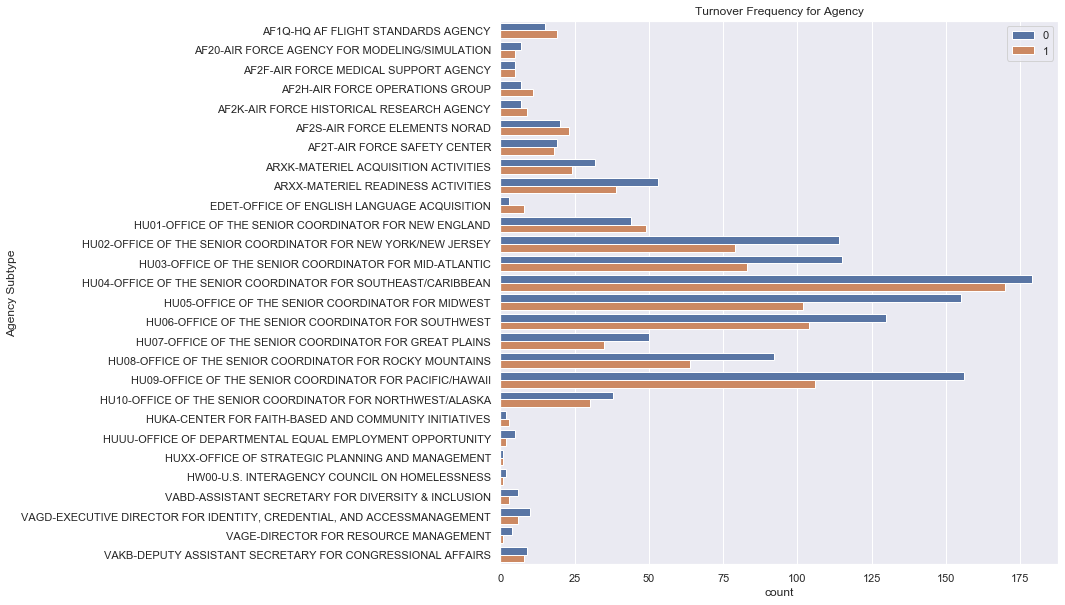

In [456]:
sns.countplot(y='AGYSUBT',hue='left',data=emp_left11)
sns.set(rc={'figure.figsize':(10,50)})
plt.ylabel('Agency Subtype')
plt.title('Turnover Frequency for Agency')
plt.legend(loc=1)  # 1 is code for 'upper right'3
#plt.legend(emp_left11['AGYSUBT'])

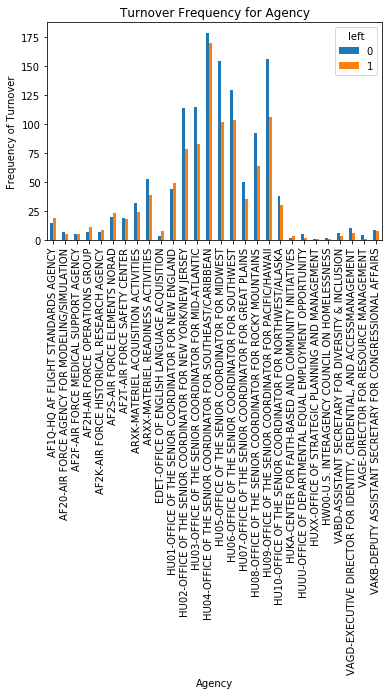

In [192]:
%matplotlib inline
import matplotlib.pyplot as plt
pd.crosstab(emp_left11.AGYSUBT,emp_left11.left).plot(kind='bar')
plt.title('Turnover Frequency for Agency')
plt.xlabel('Agency')
plt.ylabel('Frequency of Turnover')
plt.savefig('department_bar_chart')

### Histogram of Numeric Variables

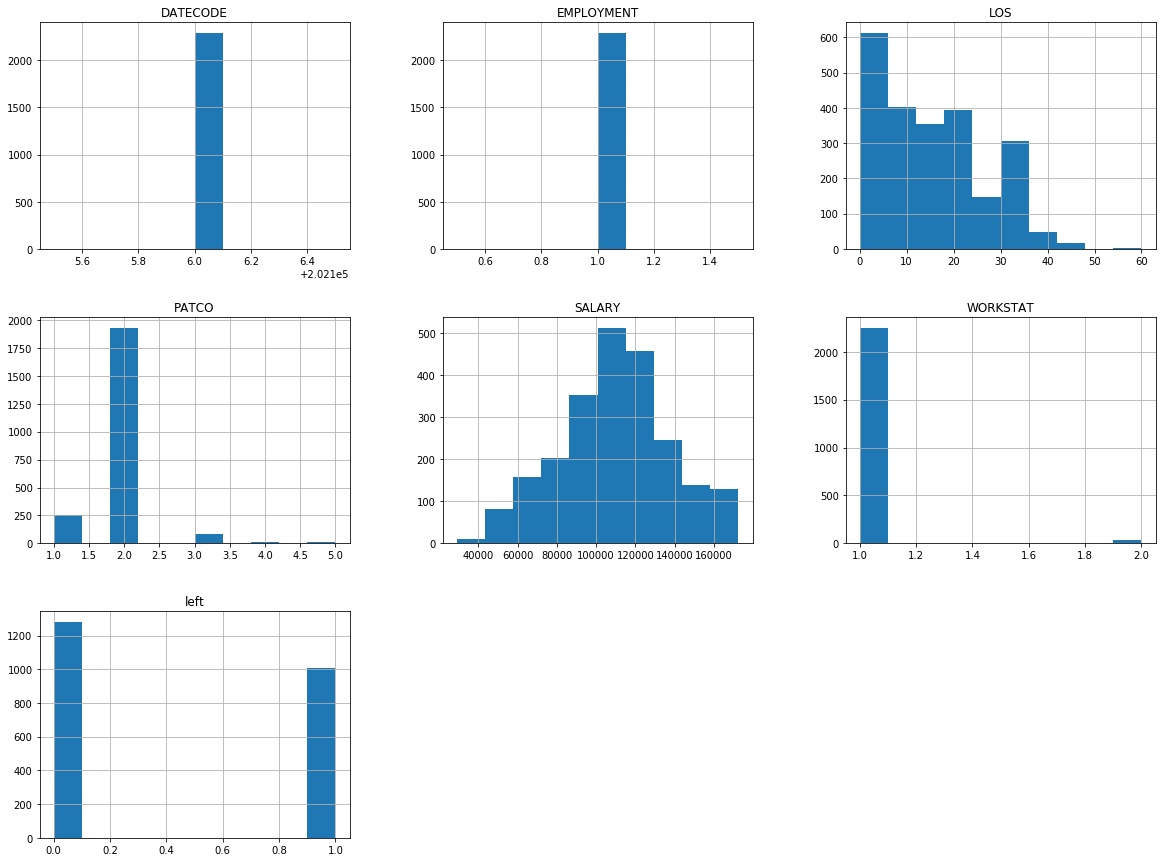

In [193]:
num_bins = 10
emp_left1.hist(bins=num_bins, figsize=(20,15))
plt.savefig("hr_histogram_plots")
plt.show()

In [397]:
cols=['SALARY', 'LOS','TOA'] 
X=emp_left1[cols]
y=emp_left1['left']

## Logistic Regression

In [398]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [399]:
from sklearn.metrics import accuracy_score
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.560


## Support Vector Machine

In [400]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [401]:
print('Support vector machine accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test))))

Support vector machine accuracy: 0.575


## Random Forest

In [407]:
from sklearn.ensemble import RandomForestClassifier
#import random
#random.seed(1234)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [408]:
print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(y_test, rf.predict(X_test))))

Random Forest Accuracy: 0.667


## Cross Validation

In [458]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = RandomForestClassifier()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.640


## Confusion Matrix

### Random Forest

In [304]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74       385
           1       0.68      0.58      0.62       302

    accuracy                           0.69       687
   macro avg       0.69      0.68      0.68       687
weighted avg       0.69      0.69      0.69       687



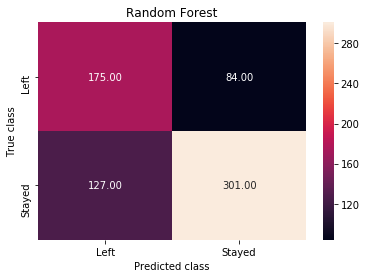

In [305]:
y_pred = rf.predict(X_test)
from sklearn.metrics import confusion_matrix
import seaborn as sns
forest_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
rx = sns.heatmap(forest_cm, annot=True, fmt='.2f',xticklabels = ["Left", "Stayed"] , yticklabels = ["Left", "Stayed"] )
bottom, top = rx.get_ylim()
rx.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')

### Logistic Regression

In [306]:
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       385
           1       0.00      0.00      0.00       302

    accuracy                           0.56       687
   macro avg       0.28      0.50      0.36       687
weighted avg       0.31      0.56      0.40       687



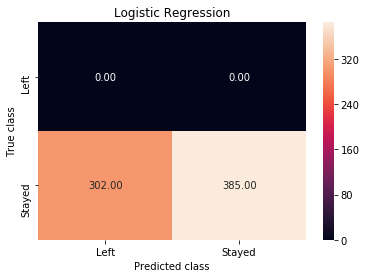

In [307]:
logreg_y_pred = logreg.predict(X_test)
logreg_cm = metrics.confusion_matrix(logreg_y_pred, y_test, [1,0])
lx = sns.heatmap(logreg_cm, annot=True, fmt='.2f',xticklabels = ["Left", "Stayed"] , yticklabels = ["Left", "Stayed"] )
bottom, top = lx.get_ylim()
lx.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Logistic Regression')
plt.savefig('logistic_regression')

### Support Vector Machine

In [308]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.87      0.70       385
           1       0.54      0.20      0.29       302

    accuracy                           0.57       687
   macro avg       0.56      0.53      0.50       687
weighted avg       0.56      0.57      0.52       687



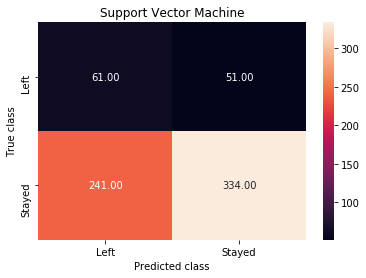

In [309]:
svc_y_pred = svc.predict(X_test)
svc_cm = metrics.confusion_matrix(svc_y_pred, y_test, [1,0])
ax = sns.heatmap(svc_cm, annot=True, fmt='.2f',xticklabels = ["Left", "Stayed"] , yticklabels = ["Left", "Stayed"] )
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Support Vector Machine')
plt.savefig('support_vector_machine')

## The ROC Curve

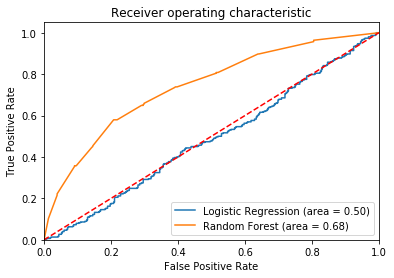

In [310]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

In [465]:
Log_Reg = print(classification_report(y_test, logreg.predict(X_test)))
RF = print(classification_report(y_test, rf.predict(X_test)))
SVM = print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.56      1.00      0.72       385
           1       0.00      0.00      0.00       302

    accuracy                           0.56       687
   macro avg       0.28      0.50      0.36       687
weighted avg       0.31      0.56      0.40       687

              precision    recall  f1-score   support

           0       0.68      0.76      0.72       385
           1       0.64      0.55      0.59       302

    accuracy                           0.67       687
   macro avg       0.66      0.65      0.65       687
weighted avg       0.66      0.67      0.66       687

              precision    recall  f1-score   support

           0       0.58      0.87      0.70       385
           1       0.54      0.20      0.29       302

    accuracy                           0.57       687
   macro avg       0.56      0.53      0.50       687
weighted avg       0.56      0.57      0.52       687



In [52]:
emp_left1.index

RangeIndex(start=0, stop=2288, step=1)

In [62]:
emp_left1.columns

Index(['AGYSUB', 'LOC', 'AGELVL', 'EDLVL', 'GSEGRD', 'LOSLVL', 'OCC', 'PATCO',
       'PP', 'PPGRD', 'SALLVL', 'STEMOCC', 'SUPERVIS', 'TOA', 'WORKSCH',
       'WORKSTAT', 'DATECODE', 'EMPLOYMENT', 'SALARY', 'LOS', 'left'],
      dtype='object')

In [71]:
emp_left1.columns.get_loc("EMPLOYMENT")

17